In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset ,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import confusion_matrix,classification_report


In [ ]:
data=load_breast_cancer()
x=data['data']
y=data['target']

x.shape,y.shape

((569, 30), (569,))

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2)
x_train.shape,y_train.shape ,x_test.shape,y_test.shape

((455, 30), (455,), (114, 30), (114,))

In [ ]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [ ]:
class HyperParameters:
  def __init__(self):
    self.number_of_epochs=50
    self.batch_size=8
    self.learning_rate=0.01
    self.shuffle=True

In [ ]:
class TrainData(Dataset):
  def __init__(self,x_train,y_train):
    self.x_train=torch.tensor(x_train,dtype=torch.float32)
    self.y_train=torch.tensor(y_train,dtype=torch.float32)

  def __getitem__(self,index):
    return self.x_train[index],self.y_train[index]

  def __len__(self):
    return len(self.x_train)
train_data=TrainData(x_train,y_train)


In [ ]:
class TestData(Dataset):
  def __init__(self,x_test):
    self.x_test=torch.tensor(x_test,dtype=torch.float32)


  def __getitem__(self,index):
    return self.x_test[index]

  def __len__(self):
    return len(self.x_test)
test_data=TestData(x_test)

In [ ]:
hyperparameters=HyperParameters()
train_loader=DataLoader(train_data,batch_size=hyperparameters.batch_size,shuffle=hyperparameters.shuffle)
test_loader=DataLoader(test_data,batch_size=1)


In [ ]:
class BreastCancerClassifier(nn.Module):
  def __init__(self,input_shape):
    super(BreastCancerClassifier,self).__init__()
    self.fc1=nn.Linear(input_shape,64)
    self.fc2=nn.Linear(64,128)
    self.fc3=nn.Linear(128,1)
  def forward(self,x):
    x=torch.relu(self.fc1(x))
    x=torch.relu(self.fc2(x))
    x=torch.sigmoid(self.fc3(x))
    return x



In [ ]:
!nvidia-smi

Thu Jun 26 01:46:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             30W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = BreastCancerClassifier(x_train.shape[1])
optimizer=optim.Adam(model.parameters(),lr=hyperparameters.learning_rate)
criterion=nn.BCELoss()
model.to(device)

BreastCancerClassifier(
  (fc1): Linear(in_features=30, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
def binary_acc(y_pred,y):
  results=torch.round(y_pred)
  correct_results_sum=(results==y).sum().float()
  acc=correct_results_sum/y.shape[0]
  acc=torch.round(acc*100)
  return acc

In [ ]:
losses=[]
accuacies=[]
model.train()
for i in range(1,hyperparameters.number_of_epochs):
  epoch_loss=0
  epoch_accuracy=0

  for data in train_loader:
    X_train,Y_train=data
    X_train,Y_train=X_train.to(device),Y_train.to(device)
    optimizer.zero_grad()
    y_pred=model(X_train)
    loss=criterion(y_pred,Y_train.reshape(-1,1))
    acc=binary_acc(y_pred,Y_train.reshape(-1,1))

    loss.backward()
    optimizer.step()

    epoch_loss+=loss.item()
    epoch_accuracy+=acc.item()

  if i%5 ==0 :
    print(f"Epoch {i+0:03}: | loss:{epoch_loss/len(train_loader):.5f}|Acc : {epoch_accuracy/len(train_loader):.3f}")
    losses.append(epoch_loss/len(train_loader))
    accuacies.append(epoch_accuracy/len(train_loader))



Epoch 005: | loss:0.03363|Acc : 99.158
Epoch 010: | loss:0.03384|Acc : 98.947
Epoch 015: | loss:0.02470|Acc : 98.947
Epoch 020: | loss:0.00683|Acc : 99.789
Epoch 025: | loss:0.00187|Acc : 100.000
Epoch 030: | loss:0.25650|Acc : 98.281
Epoch 035: | loss:0.00345|Acc : 100.000
Epoch 040: | loss:0.00048|Acc : 100.000
Epoch 045: | loss:0.00020|Acc : 100.000


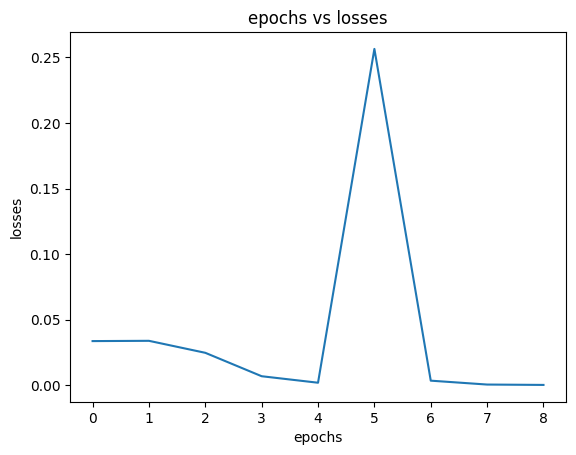

In [ ]:
plt.plot(losses)
plt.title("epochs vs losses")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.show()

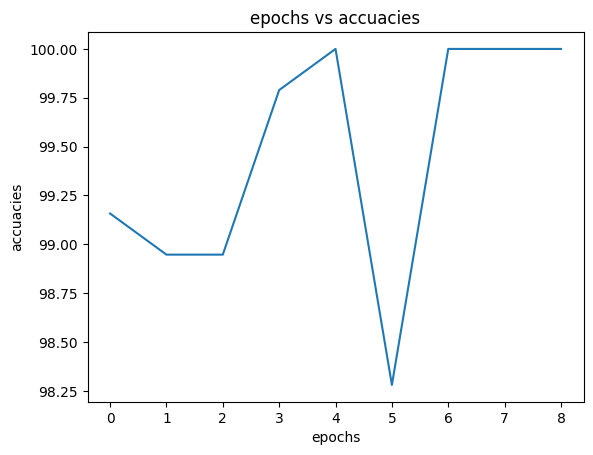

In [ ]:
plt.plot(accuacies)
plt.title("epochs vs accuacies")
plt.xlabel("epochs")
plt.ylabel("accuacies")
plt.show()

In [ ]:
y_test_pred=[]
model.eval()
with torch.no_grad():
  for X_test in test_loader:
    X_test=X_test.to(device)

    y_test_probabilities=model(X_test)
    y_test_pred.append(y_test_probabilities.cpu().numpy())

y_test_pred=[a.squeeze().tolist() for a in y_test_pred]


In [ ]:
y_test_pred = np.array(y_test_pred).flatten()

# Convert probabilities to class labels (threshold = 0.5)
y_test_pred_labels = (y_test_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_labels)
print(cm)

[[41  2]
 [ 2 69]]


In [ ]:
print(classification_report(y_test,y_test_pred_labels))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        43
           1       0.97      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

